# 特徴量作成 (LightGBM)

Predicting Road Accident Risk (Playground Series - Season 5, Episode 10)

https://www.kaggle.com/competitions/playground-series-s5e10/overview

In [1]:
import sys

sys.path.append("../utils")

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from utils import check_df

## パラメータ設定

In [2]:
class CFG:
    exp_name = "exp08-4"
    seed = 123
    n_splits = 5

    # LightGBM parameters
    num_leaves = 16
    max_depth = -1
    learning_rate = 0.1

## データ読み込み

In [3]:
class Paths:
    p = "./input/"
    train = p + "train.csv"
    test = p + "test.csv"
    sample = p + "sample_submission.csv"
    submission = f"./output/{CFG.exp_name}.csv"

In [4]:
train = pd.read_csv(Paths.train)
test = pd.read_csv(Paths.test)
train.shape, test.shape

((517754, 14), (172585, 13))

In [5]:
if False:
    display(check_df(train))
    display(check_df(test))

## 特徴量エンジニアリング

In [6]:
def _to_num(s):
    if str(s.dtype) == "category":
        return s.cat.codes.astype("int32")
    if s.dtype == "O":
        return s.astype("category").cat.codes.astype("int32")
    return s.astype("float32")

In [7]:
# New target
# https://www.kaggle.com/code/cdeotte/xgb-boosting-over-residuals-cv-0-05595
# https://www.kaggle.com/competitions/playground-series-s5e10/discussion/609994#3296622
def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = scipy.stats.norm.cdf(a), scipy.stats.norm.cdf(b)
        phi_a, phi_b = scipy.stats.norm.pdf(a), scipy.stats.norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f

In [8]:
def feature_engineering(df):
    df = df.drop(columns=["id"])
    # カテゴリ変数の処理
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in cat_cols:
        df[col] = df[col].astype("category")

    # bool型をint型に変換
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
    for col in bool_cols:
        df[col] = df[col].astype(int)

    # TODO: 追加の特徴量エンジニアリングをここに実装
    # "curvature x speed_limit"
    # df["curvature_x_speed_limit"] = df["curvature"] * df["speed_limit"]
    # speedlimit / num_lanes
    # df["speed_limit_per_num_lanes"] = df["speed_limit"] / df["num_lanes"]
    # wether + lighting
    # df["weather_lighting"] = df["weather"].astype(str) + "_" + df["lighting"].astype(str)
    # df["weather_lighting"] = df["weather_lighting"].astype("category")

    # ヨリさんの提案特徴量
    df["lighting_x_speed_limit"] = _to_num(df["lighting"]) * df["speed_limit"].astype(
        "float32"
    )
    # df["curvature_bin"]  = pd.qcut(df["curvature"],  q=5, labels=False, duplicates="drop")
    # df["weather_x_curvature_bin"] = df["weather"].astype(str) + "_x_" + df["curvature_bin"].astype(str)
    # df["weather_x_curvature_bin"] = df["weather_x_curvature_bin"].astype("category")

    # new target
    z = clip(f)(df)
    df["new_y"] = z.values

    return df

In [9]:
train_processed = feature_engineering(train)
test_processed = feature_engineering(test)

In [10]:
if True:
    display(check_df(train_processed))
    display(check_df(test_processed))

,Column,dtypes,NaN Count,Nunique,Unique Values
0,road_type,category,0,3,"[urban, rural, highway]"
1,num_lanes,int64,0,4,"[2, 4, 1, 3]"
2,curvature,float64,0,261,> 10 unique values
3,speed_limit,int64,0,5,"[35, 70, 60, 45, 25]"
4,lighting,category,0,3,"[daylight, dim, night]"
5,weather,category,0,3,"[rainy, clear, foggy]"
6,road_signs_present,int64,0,2,"[0, 1]"
7,public_road,int64,0,2,"[1, 0]"
8,time_of_day,category,0,3,"[afternoon, evening, morning]"
9,holiday,int64,0,2,"[0, 1]"


,Column,dtypes,NaN Count,Nunique,Unique Values
0,road_type,category,0,3,"[highway, urban, rural]"
1,num_lanes,int64,0,4,"[2, 3, 4, 1]"
2,curvature,float64,0,195,> 10 unique values
3,speed_limit,int64,0,5,"[45, 35, 25, 70, 60]"
4,lighting,category,0,3,"[night, dim, daylight]"
5,weather,category,0,3,"[clear, foggy, rainy]"
6,road_signs_present,int64,0,2,"[1, 0]"
7,public_road,int64,0,2,"[1, 0]"
8,time_of_day,category,0,3,"[afternoon, evening, morning]"
9,holiday,int64,0,2,"[1, 0]"


In [11]:
# データ分割
target = "accident_risk"
x_train = train_processed.drop(columns=[target])
y_train = train_processed[target]
x_test = test_processed.copy()

In [12]:
if False:
    train[target].hist(bins=50)

## クロスバリデーション

In [13]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": CFG.learning_rate,
    "num_leaves": CFG.num_leaves,
    "n_estimators": 100000,
    "random_state": CFG.seed,
    "verbose": -1,
}

In [14]:
cv = KFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

y_test_pred = np.zeros(len(x_test))
metrics = []
imp = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
    print("=" * 10, f"Fold {fold + 1}", "=" * 10)
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)

    model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        eval_metric="rmse",
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(100),
        ],
    )

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    y_test_pred += model.predict(x_test) / CFG.n_splits

    rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

    metrics.append([fold + 1, rmse_tr, rmse_va])

    _imp = pd.DataFrame(
        {
            "feature": x_train.columns,
            "importance": model.feature_importances_,
            "fold": fold + 1,
        }
    )
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

========== Fold 1 ==========
[100]	training's rmse: 0.0562143	valid_1's rmse: 0.0562165
[200]	training's rmse: 0.0559655	valid_1's rmse: 0.0560405
[300]	training's rmse: 0.0558059	valid_1's rmse: 0.0559729
[400]	training's rmse: 0.0556894	valid_1's rmse: 0.0559432
[500]	training's rmse: 0.0555885	valid_1's rmse: 0.0559304
[600]	training's rmse: 0.0554965	valid_1's rmse: 0.0559251
[700]	training's rmse: 0.0554126	valid_1's rmse: 0.0559251
========== Fold 2 ==========
[100]	training's rmse: 0.0561822	valid_1's rmse: 0.0563744
[200]	training's rmse: 0.0559281	valid_1's rmse: 0.0562098
[300]	training's rmse: 0.0557662	valid_1's rmse: 0.0561329
[400]	training's rmse: 0.0556507	valid_1's rmse: 0.0561068
[500]	training's rmse: 0.0555407	valid_1's rmse: 0.056088
[600]	training's rmse: 0.055455	valid_1's rmse: 0.0560817
[700]	training's rmse: 0.055371	valid_1's rmse: 0.0560794
========== Fold 3 ==========
[100]	training's rmse: 0.0562126	valid_1's rmse: 0.0562813
[200]	training's rmse: 0.055963

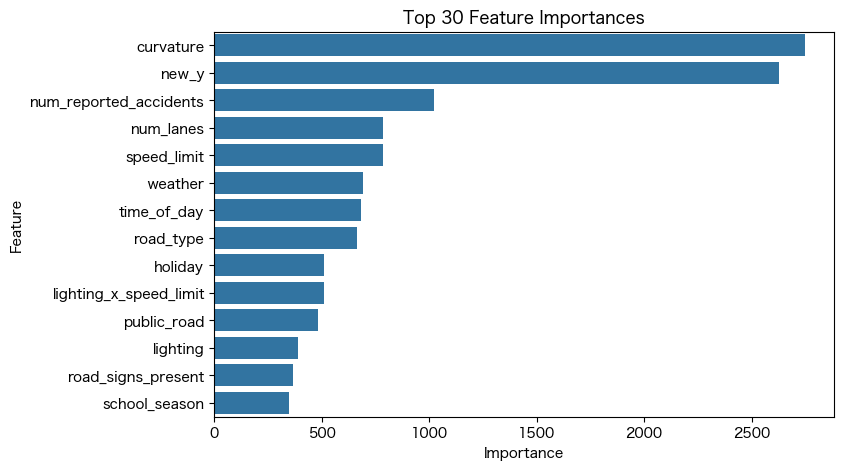

In [15]:
imp = imp.groupby("feature")["importance"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=imp.head(30).values, y=imp.head(30).index)
plt.title("Top 30 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [16]:
metrics_array = np.array(metrics)

print(
    "[cv ] tr: {:.5f} ± {:.5f}, va: {:.5f} ± {:.5f}".format(
        metrics_array[:, 1].mean(),
        metrics_array[:, 1].std(),
        metrics_array[:, 2].mean(),
        metrics_array[:, 2].std(),
    )
)

[cv ] tr: 0.05529 ± 0.00011, va: 0.05600 ± 0.00007


## 予測・提出

In [17]:
df_submit = pd.DataFrame(
    {
        "id": test["id"],
        "accident_risk": y_test_pred,
    }
)
df_submit.to_csv(Paths.submission, index=False)